# Test ellipse fit

## Imports

In [9]:
# Python standard library
import sys
import csv
import os

# Scientific computing

import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage
import sklearn.mixture

#plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

## Load data

In [10]:
date = '10-10-2017/'
particle = 'HCT-116_1/'
channel = '10-20-10_1/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events' + '.json'

In [11]:
# Load video
res_x = 384
res_y = 112
oi_fps = 250000
exposure = 500*10**(-9.)
oi_vid = oi_file.Video(oi_vid_file_path, res_x, res_y, oi_fps, exposure)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

print 'loaded', len(oi_events), 'oi events'

loaded 1140 oi events


# Create stage

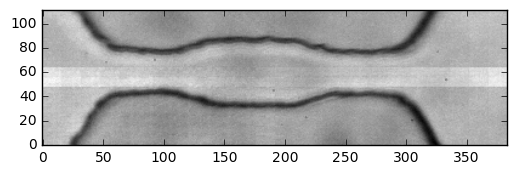

In [12]:
template_index = 1000

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

[[58, 75], [55, 45], [295, 44], [298, 75]]
[ 0.00208333  0.99999783]


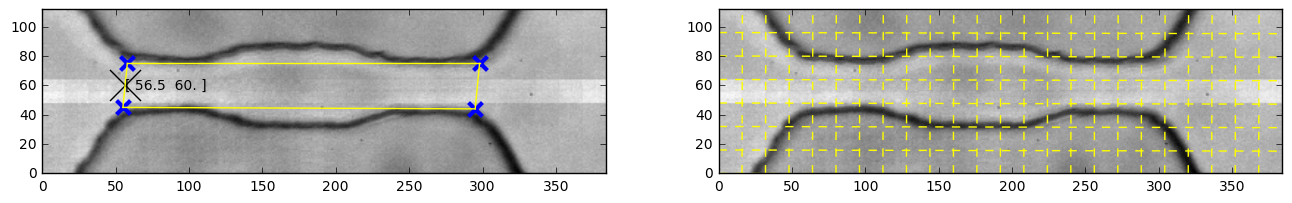

In [13]:
reload(oi)
template_frame = oi_vid.get_frame(template_index)

stage_file_path = base_path + date + particle + channel + 'oi/stage/stage_' + file_index
cs = oi.load_stage_file(stage_file_path)
print cs
c0 = cs[0]
c1 = cs[1]
c2 = cs[2]
c3 = cs[3]

oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

## Define plotting functions

In [14]:
def plot_frame(frame, show = True):
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    
    if show:
        plt.show()
    
def plot_processed_over_raw(processed_frame, frame, show = True):
    green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
    green_processed_frame[:,:,1] = processed_frame

    plt.imshow(frame, cmap = 'gray', origin = 'lower', alpha = 1, interpolation = 'none')
    plt.imshow(green_processed_frame, cmap = 'gray', origin = 'lower', alpha = 0.15, interpolation = 'none')

    if show:
        plt.show()
    
def plot_frame_hist(frame, show = True):
    plt.hist(frame.flatten(), facecolor = 'k', bins = 100)
    
    if show:
        plt.show()
    
def plot_all(processed_frame, frame):
    fig, axes = plt.subplots(1,3,figsize = (12,3))
    
    # Plot 1
    plt.sca(axes[0])
    plot_frame(processed_frame, show = False)
    
    
    # Plot 2
    plt.sca(axes[1])
    plot_processed_over_raw(processed_frame, frame, show = False)
    
    # Plot 3
    plt.sca(axes[2])
    plot_frame_hist(processed_frame, show = False)
    
    plt.show()

## Find event to test fit on

##### Frame

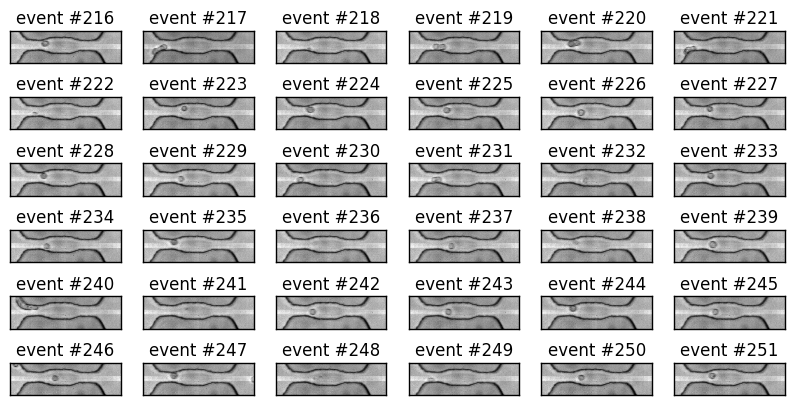

In [23]:
fig, axes = plt.subplots(6,6,figsize = (10,5))
start_index = 36*6

for i in range(36):
    oi_index = start_index + i
    oi_event = oi_events[oi_index]
    ts = oi_event.get_tf()
    t = int((ts[-1] + ts[0])/2.)
    frame = oi_vid.get_frame(t)
    
    
    row = i/6
    column = i%6
    plt.sca(axes[row, column])
    plt.imshow(frame, cmap = 'gray', origin = 'lower')
    plt.title('event #' + str(i + start_index))
    plt.xticks([])
    plt.yticks([])
plt.show()

##### Video

In [24]:
oi_index = 239
oi_event = oi_events[oi_index]
reload(oi_file)
plt.close()

#oi_file.make_animation(oi_vid, oi_event._detections[0]._tf, oi_event._detections[-1]._tf, oi_fps).save('test.mp4')
HTML(oi_file.make_animation(oi_vid, oi_event._detections[0]._tf, oi_event._detections[-1]._tf, oi_fps).to_html5_video())

## Define ellipse fitting functions

In [25]:
def crop_frame(frame, px, py, crop_distance):    
    x0 = int(px - crop_distance)
    x1 = int(px + crop_distance)
    y0 = int(py - crop_distance)
    y1 = int(py + crop_distance)
    
    

    
    cropped_frame = np.copy(frame)[y0:y1, x0:x1]
    
    return cropped_frame
    

preprocessing_steps = []



        


def preprocess_fit_ellipse(raw_frame, raw_template_frame, detection, debug = 'none'):

    
    
    
    # Refresh list
    del preprocessing_steps[:]

    

    
    #################################
    # Copy
    #################################
    
    
    
    preprocessing_steps.append(['copy'])

    processed_template_frame = np.copy(raw_template_frame)
    processed_frame = np.copy(raw_frame)
    

    if debug == 'all':
        print 'copy'
        plot_all(processed_frame, raw_frame)
        
    #################################
    # Normalize
    #################################
    processed_template_frame = processed_template_frame/np.mean(processed_template_frame)
    processed_frame = processed_frame/np.mean(processed_frame)
    
        
    #################################
    # Crop
    #################################
    
    crop_distance = 30
    
    preprocessing_steps.append(['crop'] + [crop_distance])

    processed_frame = crop_frame(processed_frame, detection._px, detection._py, crop_distance)
    processed_template_frame = crop_frame(processed_template_frame, detection._px, detection._py, crop_distance)
    frame = np.copy(processed_frame)

    if debug == 'all':
        print 'crop'
        plot_all(processed_frame, frame)
        
        




    #################################
    # Blur
    #################################


    blur_kernel = (3, 3)    # 19
    preprocessing_steps.append(['gaussian blur', blur_kernel])

    
    processed_frame = cv2.GaussianBlur(processed_frame, blur_kernel, 0)
    processed_template_frame = cv2.GaussianBlur(processed_template_frame, blur_kernel, 0)
    


    if debug == 'all':
        print 'gaussian blur', blur_kernel
        plot_all(processed_frame, frame)
    
    

        
        

    '''    
    #################################
    # Processed-template Negative
    #################################

    
    
    preprocessing_steps.append(['processed-template negative'])

    processed_frame = processed_template_frame - processed_frame


    if debug == 'all':
        print 'processed-template negative'
        plot_all(processed_frame, frame)
    
    '''
    
     
    #################################
    # Processed-template Negative
    #################################

    
    
    preprocessing_steps.append(['template - processed negative'])

    processed_frame = -(processed_frame - processed_template_frame)


    if debug == 'all':
        print 'processed-template negative'
        plot_all(processed_frame, frame)
    
    
        
    '''
    #################################
    # Abs Negative
    #################################


    preprocessing_steps.append(['abs negative'])

    processed_frame = np.abs(processed_template_frame - processed_frame)


    if debug == 'all':
        print 'abs negative'
        plot_all(processed_frame, frame)


    '''
    

    
    
    '''
    #################################
    # Gradient
    #################################
    
    preprocessing_steps.append(['gradient'])

    processed_frame = cv2.Laplacian(processed_frame, cv2.CV_64F)



    if debug == 'all':
        print 'gradient'
        plot_all(processed_frame, frame)
    '''
    #################################
    # Inversion
    #################################
    '''
    preprocessing_steps.append(['inversion'])

    processed_frame = 1-processed_frame



    if debug == 'all':
        print 'inversion'
        plot_all(processed_frame, frame)
    
    
    
     
    '''
    

    
    #################################
    # Rescale
    #################################
    
    preprocessing_steps.append(['rescale'])

    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))

    

    if debug == 'all':
        print 'rescale'
        plot_all(processed_frame, frame)
    
    
    
    
    '''
    ##################################
    # 2 Gaussian-based thresholding
    ##################################
    
    model = sklearn.mixture.GaussianMixture(n_components=2, covariance_type='full')
    model.fit(processed_frame.reshape(-1,1))
    
    
    
    
    weights = model.weights_.flatten()
    means = model.means_.flatten()
    covariances = model.covariances_.flatten()
 
    sigma = 0.5
    
    index = 1
    if means[0] > means[1]:
        index = 0
    
    threshold = means[index] - sigma*covariances[index]**.5
    
    processed_frame[processed_frame < threshold] = 0
    processed_frame[processed_frame > threshold] = 1
    
    
    
    if debug == 'all':
        print 'gaussian-based thresholding', 'sigma = ', sigma
        plot_all(processed_frame, frame)
        
    '''
    
    
    ##################################
    # Single Gaussian-based thresholding
    ##################################
    
    model = sklearn.mixture.GaussianMixture(n_components=1, covariance_type='full')
    model.fit(processed_frame.reshape(-1,1))
    
    
    
    
    weight = model.weights_.flatten()[0]
    mean = model.means_.flatten()[0]
    covariance = model.covariances_.flatten()[0]
 
    sigma = 1
    
    

    threshold = mean + sigma*(covariance**.5)
    
    processed_frame[processed_frame < threshold] = 0
    processed_frame[processed_frame >= threshold] = 1
    
    
    
    if debug == 'all':
        
        print 'single gaussian-based thresholding', 'sigma = ', sigma
        print 'mean', mean, 'covariance', covariance
        plot_all(processed_frame, frame)
        
        
    
    
    
    '''
    ##################################
    # Adaptive thresholding histogram derivative
    ##################################
    
    
    sigma = 3
    threshold_factor = 3.
    preprocessing_steps.append(['adaptive thresholding histogram derivative, sigma = ', sigma, 'threshold_factor = ', threshold_factor])

    
            
    total_bins = 100

    counts, bins = np.histogram(processed_frame, bins = 100)

    
    smoothed_counts = scipy.ndimage.filters.gaussian_filter(counts, sigma = 3)


    derivative_smoothed_counts = np.gradient(smoothed_counts)


    derivative_threshold = np.abs(np.min(derivative_smoothed_counts)/threshold_factor)

    for i in range(len(derivative_smoothed_counts)):
        if np.abs(derivative_smoothed_counts[-1-i]) > derivative_threshold:
            index = -1-i
            break
            
    threshold = (bins[index] + bins[index-1])/2.

    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0
    processed_frame = processed_frame.astype(int)
    
    if debug == 'all':
        print 'adaptive thresholding histogram derivative, sigma = ', sigma, 'derivative threshold = half max'
        plot_all(processed_frame, frame)
    
    '''

    
    ''' 

    #################################    
    # Get largest cluster
    #################################
    
    preprocessing_steps.append(['clustering (retain largest cluster)'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1





    if debug == 'all':
        print 'cluster'
        plot_all(processed_frame, frame)
    
    '''
    
    #################################    
    # Percentage Based Clustering
    #################################
    '''
    percentage_of_largest = .15
    preprocessing_steps.append(['percentage based clustering = ', str(percentage_of_largest)])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)

    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]

    cluster_threshold =  int(len(largest_cluster) * percentage_of_largest)
    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True, cluster_threshold = cluster_threshold)
    
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for cluster in clusters:
        for pixel in cluster:
            processed_frame[pixel[0], pixel[1]] = 1
            
    if debug == 'all':
        print 'percentage based cluster threshold', percentage_of_largest
        plot_all(processed_frame, frame)
    '''
    
    #################################    
    # Cluster filtering
    #################################
    
    
    cluster_threshold = 25
    preprocessing_steps.append(['cluster filtering, threshold = ', str(cluster_threshold)])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0],\
                                                                            processed_frame.shape[1])),\
                                                 diag = True, cluster_threshold = cluster_threshold)
    
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for cluster in clusters:
        for pixel in cluster:
            processed_frame[pixel[0], pixel[1]] = 1





    if debug == 'all':
        print 'cluster threshold', cluster_threshold
        plot_all(processed_frame, frame)
    
    
    
    
    #################################
    # Pad (numpy)
    #################################
    
    
    pad_width = 20
    #processing_steps.append('pad, pad width = ', pad_width)
    
    processed_frame = np.lib.pad(processed_frame, pad_width, 'constant')
    
    
    if debug == 'all':
        #print 'pad, width = ', pad_width
        plot_all(processed_frame, frame)
    
    
    #################################
    # Morphological closing (opencv)
    #################################
    
    morph_kernel_size = (45,45) #15
    preprocessing_steps.append(['morphological closing, kernel = ', morph_kernel_size])

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)


    if debug == 'all':
        print 'morphological closing'
        plot_all(processed_frame, frame)
    
    
    
    #################################
    # Unpad (numpy)
    #################################
    
    processed_frame = processed_frame[pad_width:-pad_width, pad_width:-pad_width]
    
    
    
    
    
    if debug == 'all':
        #print 'rescale'
        plot_all(processed_frame, frame)
     
    
    
    
    

    #################################
    # Erode subtraction
    #################################
    
    iterations = 3
    
    
    preprocessing_steps.append(['erosion subtraction, iterations = ', iterations])
    if iterations > 1:
    
        processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = iterations - 1)
        
    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)
        
    



    


    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)
    
        
        
        
        
    
    
        
        
        
    #################################
    # Dilate subtraction
    #################################
    '''
    iterations = 3
    preprocessing_steps.append(['dilation subtraction, iterations = ', iterations])

    processed_frame = scipy.ndimage.binary_dilation(processed_frame) - processed_frame


    if debug == 'all':
        print 'dilate subtraction'
        plot_all(processed_frame, frame)
    
    '''
    
    
    
        
        
        
    
 


    ###################################
    # Fit ellipse
    ###################################


    cell_pixels = np.where(processed_frame == 1)

    
    
    
    ellipse = oi.fit_ellipse_image_aligned(cell_pixels[1], cell_pixels[0])

    
    # Center
    ellipse_center = oi.get_ellipse_center(ellipse)
    ellipse_center_adjusted = [ellipse_center[0] + detection._px - crop_distance, ellipse_center[1] + detection._py - crop_distance]

    # Axes
    ellipse_axes_lengths = oi.get_ellipse_axes_lengths(ellipse)
    
    # Angle
    ellipse_angle = oi.get_ellipse_angle(ellipse)

    
    
    if debug != 'none':
        # Create perimeter line
        ellipse_points = np.empty((100,2))
        for i in range(100):
            angle = i*2*np.pi/99.
            x = ellipse_axes_lengths[0]*np.cos(angle)
            y = ellipse_axes_lengths[1]*np.sin(angle)
            ellipse_points[i,0] = ellipse_center[0] + np.cos(ellipse_angle)*x + np.sin(ellipse_angle)*y
            ellipse_points[i,1] = ellipse_center[1] + np.sin(ellipse_angle)*x - np.cos(ellipse_angle)*y

        # Turn pixels green
        green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
        green_processed_frame[:,:,1] = processed_frame

        # Begin plot
        fig, axes = plt.subplots(1,3,figsize = (9,3))

        
        # Axes 0
        plt.sca(axes[0])
        
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(np.zeros(frame.shape), alpha = 0.5, cmap = 'gray')
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])
        
        plt.xticks([])
        plt.yticks([])

        
        # Axes 1
        plt.sca(axes[1])
        
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .5, origin = 'lower', interpolation = 'none')
        #plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 3, c = 'red')

        #plt.scatter(ellipse_center[0], ellipse_center[1], marker = 'x', lw = 5, color = 'red', s = 50)
        
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])
        
        plt.xticks([])
        plt.yticks([])
        
        # Axes 2
        plt.sca(axes[2])
        
        '''plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(np.zeros(frame.shape), cmap = 'gray', alpha = 0.5)'''
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .5, origin = 'lower', interpolation = 'none')
        #plt.imshow(processed_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        #plt.imshow(green_processed_frame, alpha = .35, origin = 'lower', interpolation = 'none', zorder = 10)
        plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 1, ls = '--', c = 'white')

        #plt.scatter(ellipse_center[0], ellipse_center[1], marker = 'x', c = 'white', lw = 3, s = 20)
        
        
        ellipse_axis_a = [ellipse_axes_lengths[0]*np.cos(ellipse_angle), ellipse_axes_lengths[0]*np.sin(ellipse_angle)]
        ellipse_axis_b = [ellipse_axes_lengths[1]*np.sin(ellipse_angle), -ellipse_axes_lengths[1]*np.cos(ellipse_angle)]

        
        ax0 = ellipse_center[0]
        ax1 = ax0 + ellipse_axis_a[0]
        ay0 = ellipse_center[1]
        ay1 = ay0 + ellipse_axis_a[1]
        
        bx0 = ellipse_center[0]
        bx1 = bx0 + ellipse_axis_b[0]
        by0 = ellipse_center[1]
        by1 = by0 + ellipse_axis_b[1]
        
        plt.plot([ax0, ax1], [ay0, ay1], lw = 1, ls = '--', c = 'white')
        plt.plot([bx0, bx1], [by0, by1], lw = 1, ls = '--', c = 'white')
        
        #plt.text((ax0+ax1)/2., (ay0+ay1)/2., 'a', color = 'white', size = 20, ha = 'left', va = 'bottom', fontweight = 'bold')
        
        
        #plt.text((bx0+bx1)/2., (by0+by1)/2., 'b', color = 'white', size = 20, ha = 'left', va = 'bottom', fontweight = 'bold')
        plt.text(ax1 + 4, ay1, 'a', color = 'white', size = 32, ha = 'left', va = 'center', fontweight = 'bold')
        plt.text(bx1, by1 - 4, 'b', color = 'white', size = 32, ha = 'center', va = 'top', fontweight = 'bold')
        
        
        
        a_um = oi_stage.pixels_to_meters(ellipse_axes_lengths[0])
        b_um = oi_stage.pixels_to_meters(ellipse_axes_lengths[1])
        
        #plt.text(0, 0.9, r'a='+str(round(a_um,2)) + r'$\mu$m', transform=plt.gca().transAxes, ha = 'left', va = 'bottom', size = 16, color = 'white', fontweight = 'bold')
        #plt.text(0, 0.8, r'b='+str(round(b_um,2)) + r'$\mu$m', transform=plt.gca().transAxes, ha = 'left', va = 'bottom', size = 16, color = 'white', fontweight = 'bold')
        plt.text(0, 1.0, r'a/b=' + str(round(a_um/b_um, 2)), transform = plt.gca().transAxes, ha = 'left', va = 'top', size = 18, color = 'white', fontweight = 'bold')
        plt.text(0, 0.9, r'$\theta=$'+str(round(ellipse_angle*180./np.pi,3)), transform=plt.gca().transAxes, ha = 'left', va = 'top', size = 18, color = 'white', fontweight = 'bold')
        
        
        
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])
        
        plt.xticks([])
        plt.yticks([])
        
        
        fig.tight_layout()
                
        plt.show()
        
        
    return [ellipse_center_adjusted[0], ellipse_center_adjusted[1], ellipse_axes_lengths[0], ellipse_axes_lengths[1], ellipse_angle]


##### Test fit

0 -33.3933850261
failed on  0 18
(<type 'exceptions.TypeError'>, '<ipython-input-26-232775c50257>', 25)
1 -31.3514245972
failed on  1 18
(<type 'exceptions.TypeError'>, '<ipython-input-26-232775c50257>', 25)
2 -28.8405325221
failed on  2 18
(<type 'exceptions.TypeError'>, '<ipython-input-26-232775c50257>', 25)
3 -23.3221190644
failed on  3 18
(<type 'exceptions.TypeError'>, '<ipython-input-26-232775c50257>', 25)
4 -16.0472779398


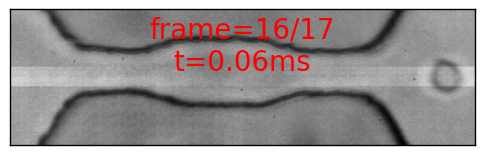

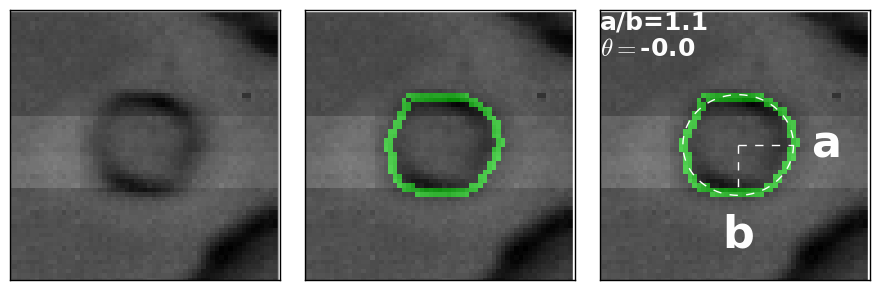

5 -6.22937382434


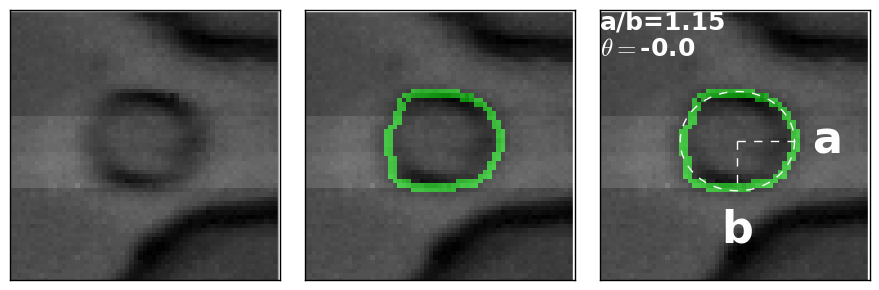

6 8.54163853617


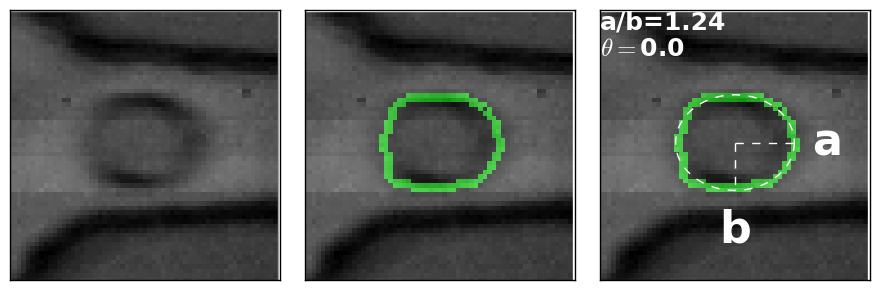

7 27.7708830664


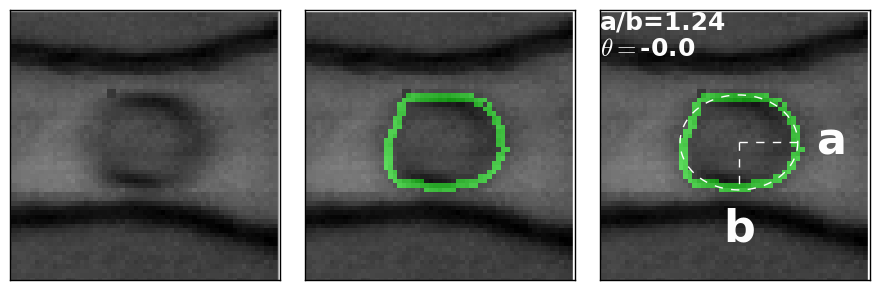

8 47.998381346


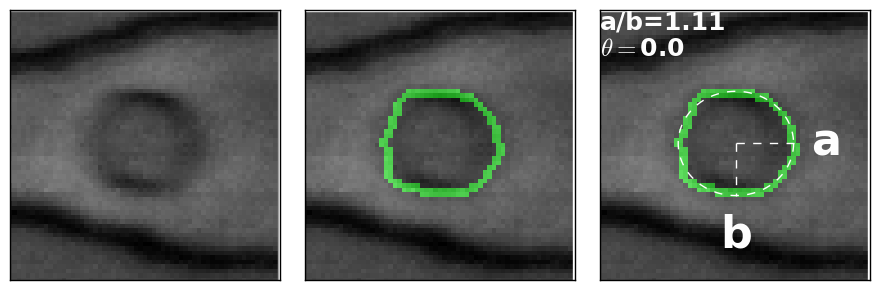

9 65.821690904


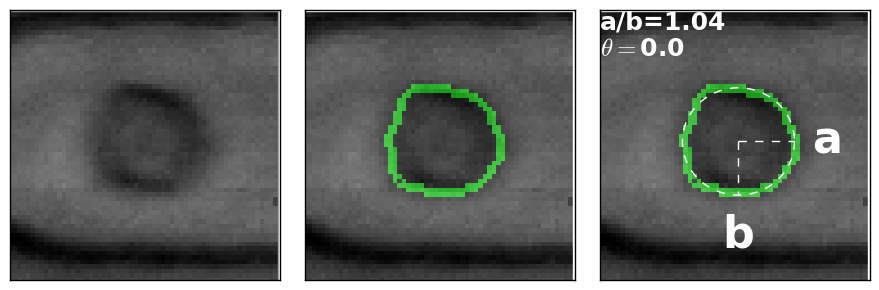

10 82.3613137781


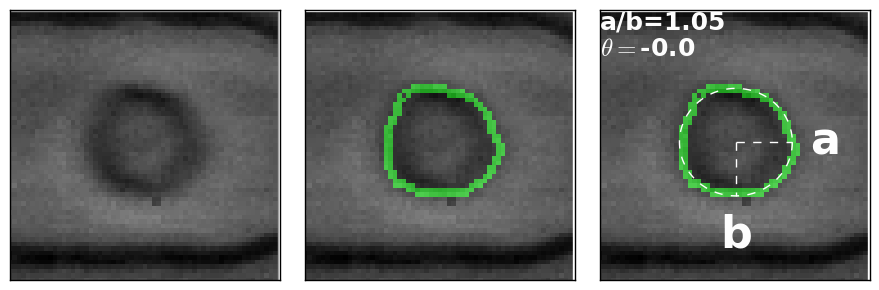

11 98.1506572401


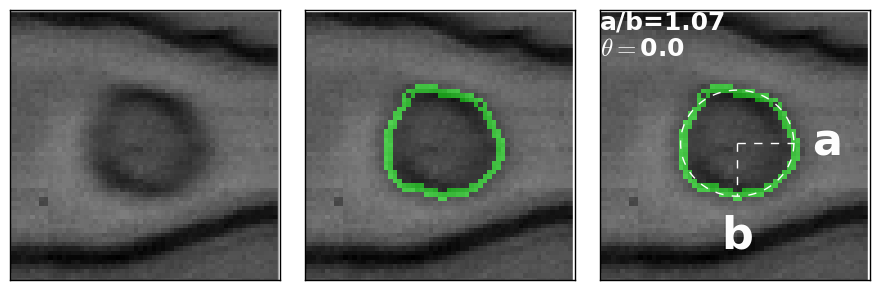

12 115.843721661


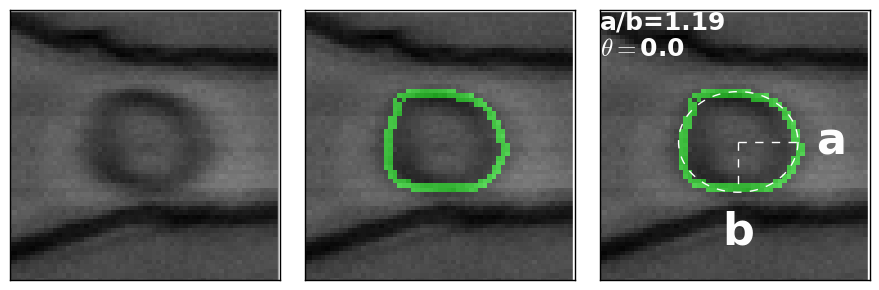

13 136.310416814


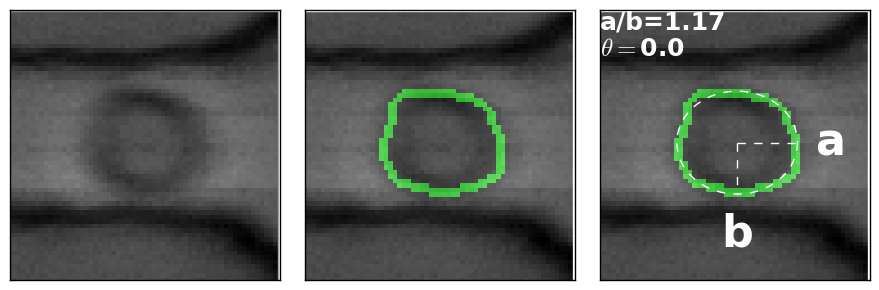

14 156.713452023


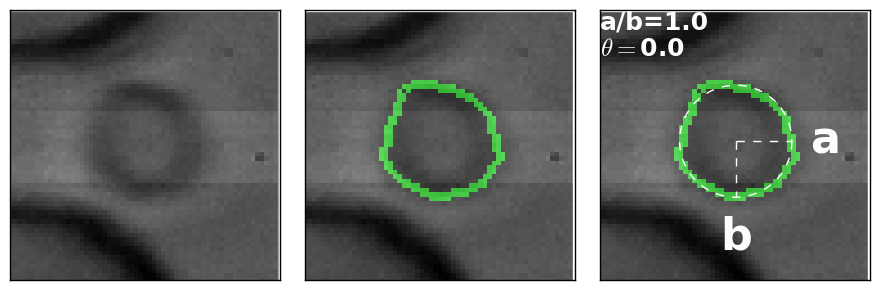

15 174.307965188


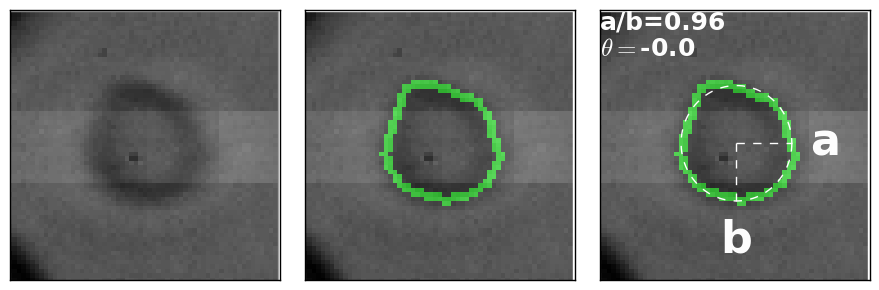

16 189.114975123


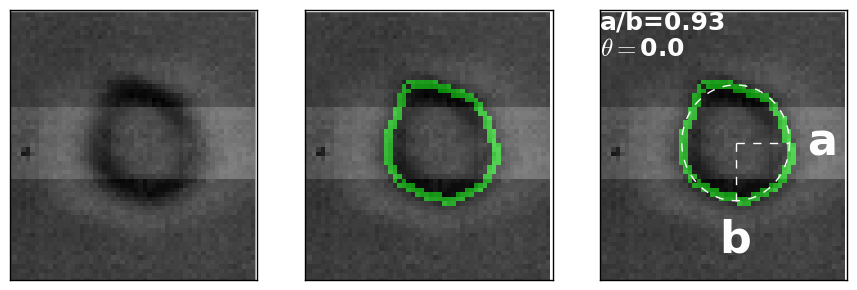

17 199.729643554


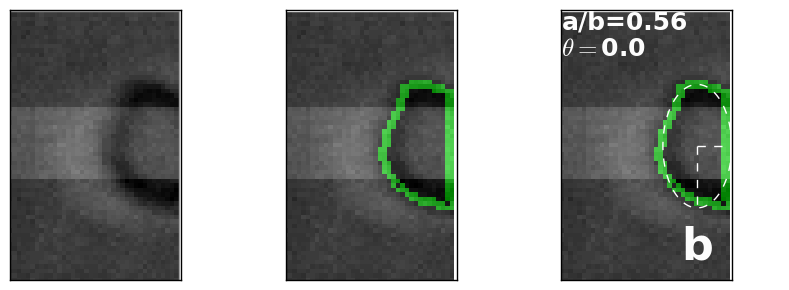

In [26]:
xs = oi_event.get_px()
ys = oi_event.get_py()

xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)

xcs = oi_stage.pixels_to_meters(xcs)


xc_left = -100
xc_right = 400

for j, detection in enumerate(oi_event._detections):
    try:
        if xcs[j] >= xc_left and xcs[j] <= xc_right:
            
            print j, xcs[j]



            # Get raw frame
            raw_frame = oi_vid.get_frame(detection._tf)

            
            # Get ellipse/preprocess the frame
            ellipse = preprocess_fit_ellipse(raw_frame, template_frame, detection, debug = 'last')
            
            
    except Exception as e:
        print 'failed on ', j, len(oi_event._detections)
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(exc_type, fname, exc_tb.tb_lineno)
        pass

##### Test determined ellipse parameters

failed on  0 18
failed on  1 18
failed on  2 18
failed on  3 18


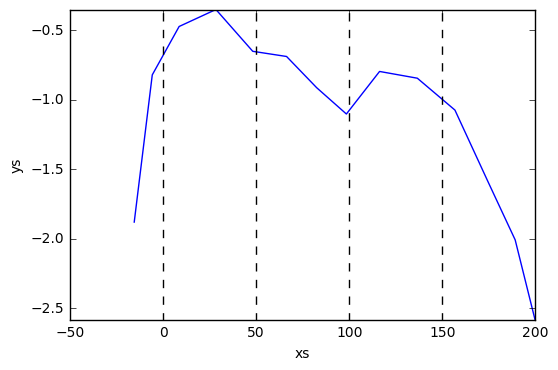

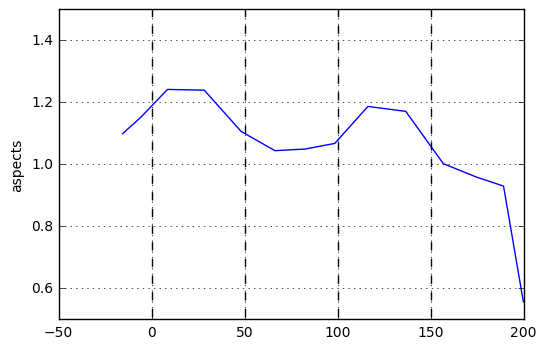

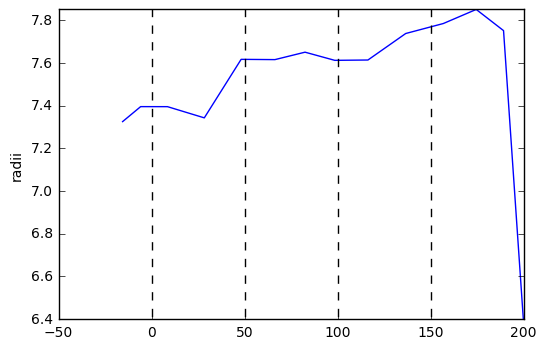

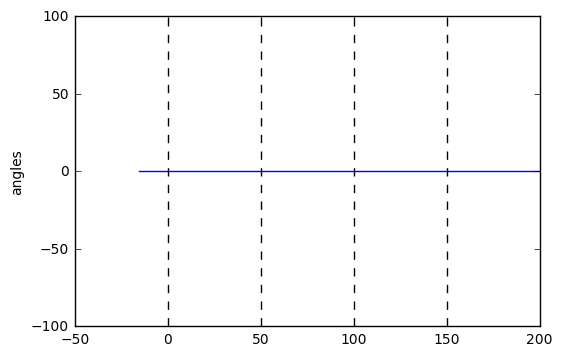

In [27]:
xs = oi_event.get_px()
ys = oi_event.get_py()

xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)

xcs = oi_stage.pixels_to_meters(xcs)


ellipse_xs = []
ellipse_ys = []
ellipse_as = []
ellipse_bs = []
ellipse_aspects = []
ellipse_angles = []
ellipse_radii = []

for j, detection in enumerate(oi_event._detections):
    try:

        # Get raw frame
        raw_frame = oi_vid.get_frame(detection._tf)


        ellipse = preprocess_fit_ellipse(raw_frame, template_frame, detection, debug = 'none')

        # Get ellipse parameters
        x = ellipse[0]
        y = ellipse[1]
        
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        xc = oi_stage.pixels_to_meters(xc)
        yc = oi_stage.pixels_to_meters(yc)
        
        ellipse_xs.append(xc)
        ellipse_ys.append(yc)

        # Axes
        ellipse_a = ellipse[2]
        ellipse_b = ellipse[3]
        
        ellipse_angle = ellipse[4]
        
        ellipse_as.append(ellipse_a)
        ellipse_bs.append(ellipse_b)
        
        
        # Radius
        ellipse_radius = np.sqrt(ellipse_a*ellipse_b)
        ellipse_radius = oi_stage.pixels_to_meters(ellipse_radius)
        ellipse_radii.append(ellipse_radius)
        
        # Ellipse aspect
        ellipse_aspects.append(ellipse_a/ellipse_b)
        
    
        ellipse_a_rot = np.cos

            
        
        # Angle
        ellipse_angles.append(180.*ellipse[4]/np.pi)
        
        
        
        
        
            
            
    except:
        print 'failed on ', j, len(oi_event._detections)
        pass
    
    
ellipse_radii = np.array(ellipse_radii)
ellipse_aspects = np.array(ellipse_aspects)
ellipse_angles = np.array(ellipse_angles)
    
    
'''plt.plot(ellipse_xs)
plt.ylabel('xs')
plt.show()



plt.plot(ellipse_ys)
plt.ylabel('ys')
plt.show()
'''
# Trajectory
plt.plot(ellipse_xs, ellipse_ys)
plt.plot([0,0],[-100,100], ls = '--', c = 'k')
plt.plot([50,50],[-100,100], ls = '--', c = 'k')
plt.plot([100,100],[-100,100], ls = '--', c = 'k')
plt.plot([150,150],[-100,100], ls = '--', c = 'k')
plt.ylim(np.min(ellipse_ys), np.max(ellipse_ys))
plt.xlabel('xs')
plt.ylabel('ys')
plt.show()


# Aspects
plt.plot(ellipse_xs, ellipse_aspects)
plt.plot([0,0],[-100,100], ls = '--', c = 'k')
plt.plot([50,50],[-100,100], ls = '--', c = 'k')
plt.plot([100,100],[-100,100], ls = '--', c = 'k')
plt.plot([150,150],[-100,100], ls = '--', c = 'k')
plt.ylabel('aspects')
plt.grid()
plt.ylim(0.5,1.5)
plt.show()


# Radii
plt.plot(ellipse_xs, ellipse_radii)
plt.plot([0,0],[-100,100], ls = '--', c = 'k')
plt.plot([50,50],[-100,100], ls = '--', c = 'k')
plt.plot([100,100],[-100,100], ls = '--', c = 'k')
plt.plot([150,150],[-100,100], ls = '--', c = 'k')
plt.ylabel('radii')
plt.ylim(np.min(ellipse_radii[np.isfinite(ellipse_radii)]), np.max(ellipse_radii[np.isfinite(ellipse_radii)]))
plt.show()


# Angles
plt.plot(ellipse_xs, ellipse_angles)
plt.plot([0,0],[-100,100], ls = '--', c = 'k')
plt.plot([50,50],[-100,100], ls = '--', c = 'k')
plt.plot([100,100],[-100,100], ls = '--', c = 'k')
plt.plot([150,150],[-100,100], ls = '--', c = 'k')
plt.ylabel('angles')
plt.show()